https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
learning_rate = 0.001
weight_decay = 0.0001
learning_rate = 1e-3
batch_size = 128
num_epochs = 100
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1
num_epochs = 100
image_size = 120  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

(train_ds, valid_ds), info = tfds.load("oxford_flowers102", split=["test", "validation"], as_supervised=True, with_info=True)
int_to_class_label = info.features['label'].int2str
num_classes = 102
IMG_WIDTH = IMG_HEIGHT = image_size
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

CLASSES_TO_CONSIDER = list(range(num_classes)) 


def preprocess_image(image, label, height, width):
    image = tf.image.resize(image, [height,width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def filter_by_classes(img, label):
    bools = tf.equal(label, CLASSES_TO_CONSIDER)
    return tf.reduce_any(bools)    


partial_preprocess_image = functools.partial(preprocess_image, height=IMG_HEIGHT, width=IMG_WIDTH)
train_ds = train_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
valid_ds = valid_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
def get_x_y_from_ds(ds):
    x, y = [], []
    for img, label in ds.cache().as_numpy_iterator():
        x.append(img)
        y.append(label)

    return np.array(x), np.array(y)

x_train, y_train = get_x_y_from_ds(train_ds)
x_test, y_test = get_x_y_from_ds(valid_ds)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [7]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [12]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=60,#num_epochs,
        validation_split=0.1,
        validation_data = (x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/60
49/49 [==============================] - 19s 182ms/step - loss: 4.7979 - accuracy: 0.0551 - top-5-accuracy: 0.1834 - val_loss: 4.2161 - val_accuracy: 0.0559 - val_top-5-accuracy: 0.1931
Epoch 2/60
49/49 [==============================] - 7s 151ms/step - loss: 4.1034 - accuracy: 0.0877 - top-5-accuracy: 0.2620 - val_loss: 3.8764 - val_accuracy: 0.1020 - val_top-5-accuracy: 0.2814
Epoch 3/60
49/49 [==============================] - 7s 152ms/step - loss: 3.8144 - accuracy: 0.1186 - top-5-accuracy: 0.3474 - val_loss: 3.6310 - val_accuracy: 0.1176 - val_top-5-accuracy: 0.3549
Epoch 4/60
49/49 [==============================] - 8s 161ms/step - loss: 3.5660 - accuracy: 0.1460 - top-5-accuracy: 0.4001 - val_loss: 3.4002 - val_accuracy: 0.1529 - val_top-5-accuracy: 0.4216
Epoch 5/60
49/49 [==============================] - 7s 151ms/step - loss: 3.3529 - accuracy: 0.1810 - top-5-accuracy: 0.4526 - val_loss: 3.2817 - val_accuracy: 0.1706 - val_top-5-accuracy: 0.4735
Epoch 6/60
49/49 [=

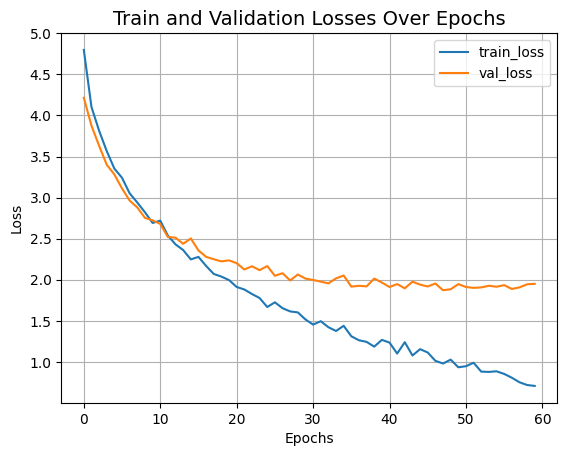

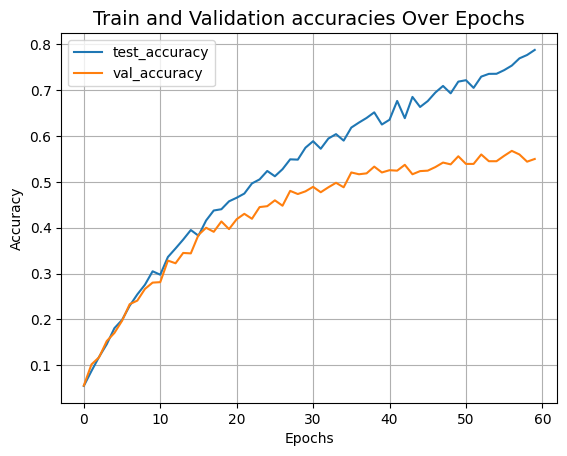

In [13]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["accuracy"], label="test_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [14]:
y_pred = vit_classifier.predict(x_test)
predicted_ids = np.argmax(y_pred, axis=-1)
true_classes = np.argmax(y_test, axis=-1)
accuracy = np.mean(predicted_ids == true_classes)
print('Precisão:', accuracy)

32/32 [==============================] - 2s 21ms/step
Precisão: 0.5676470588235294


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Calcular a precisão, recall e F1-score para cada classe
report = classification_report(true_classes, predicted_ids, target_names=np.array(info.features['label'].names))

# Exibir o relatório de classificação
print(report)

                           precision    recall  f1-score   support

            pink primrose       0.83      0.50      0.62        10
hard-leaved pocket orchid       1.00      1.00      1.00        10
         canterbury bells       0.33      0.10      0.15        10
                sweet pea       1.00      0.20      0.33        10
         english marigold       0.71      0.50      0.59        10
               tiger lily       0.80      0.80      0.80        10
              moon orchid       0.60      0.30      0.40        10
         bird of paradise       0.82      0.90      0.86        10
                monkshood       0.71      0.50      0.59        10
            globe thistle       0.67      0.80      0.73        10
               snapdragon       0.23      0.30      0.26        10
              colt's foot       0.82      0.90      0.86        10
              king protea       1.00      0.90      0.95        10
            spear thistle       0.78      0.70      0.74     

In [11]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 120, 120, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches (Patches)              (None, None, 432)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 100, 64)      34112       ['patches[0][0]']            